# Building a Predictive Model Based on Provided Data


### 1.1 Import Dependencies

In [1]:
!pip install matplotlib==3.8.1
!pip install pandas==2.1.2
!pip install scikit-learn==1.3.2
!pip install seaborn==0.13.0
!pip install tensorflow==2.14.0

In [223]:
# Data Manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Predictive Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score


### 1.2 Initialize Constant Variables

In [140]:
# Paths for data
FEATURES_PATH = "features.csv"
TARGETS_PATH = "targets.csv"

# Fraction of axis items to return in percentage (due to its significant size for EDA, especially in the context of pair plots)
FRAC = 0.1

# Seed
RANDOM_STATE = 42

### 1.3 Load Dataset

Since I am working with 2 files, I need to merge them into a single DataFrame. I will merge on the *id* column.

In [155]:
df_features = pd.read_csv(FEATURES_PATH, sep=';')
df_targets = pd.read_csv(TARGETS_PATH, sep=';')

df = df_features.merge(df_targets, how="inner", on="id")

### 1.4 Numerical inspection

In [156]:
df.shape

(4178, 12)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4178 entries, 0 to 4177
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      4178 non-null   object 
 1   f_0     4110 non-null   object 
 2   f_1     4177 non-null   float64
 3   f_2     3764 non-null   float64
 4   f_3     4177 non-null   float64
 5   f_4     4177 non-null   float64
 6   f_5     4177 non-null   float64
 7   f_6     4177 non-null   float64
 8   f_7     4177 non-null   float64
 9   f_8     4177 non-null   object 
 10  f_9     4177 non-null   float64
 11  target  4178 non-null   int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 391.8+ KB


In [158]:
df.head()

,id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,target
0,b03a97185bcd4e3297fffcbe7360c64d,F,0.495,0.400,1550.0,0.6445,0.2420,0.1325,0.205,SHORT,1.025113,1
1,84ab6aeda37c4943847d204c120410df,M,0.630,0.515,1550.0,1.2590,0.4105,0.1970,0.410,SHORT,2.006427,1
2,dcbb537ee552433780fde6dfb1d941c6,F,0.595,0.465,1550.0,1.0260,0.4645,0.1120,0.305,SHORT,2.430176,0
3,e9cc5c8b303045a783e11df15389cd39,M,0.360,0.295,1000.0,0.2105,0.0660,0.0525,0.075,SHORT,1.451025,0
4,bd8ca64a21fd4edeb3db59ce5db871bc,M,0.600,0.510,1850.0,1.2850,0.6095,0.2745,0.315,SHORT,2.701401,0


In [159]:
df.describe().apply(lambda x: x.apply("{0:.2f}".format))

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_9,target
count,4177.00,3764.00,4177.00,4177.00,4177.00,4177.00,4177.00,4177.00,4178.00
mean,0.52,0.41,1395.16,0.83,0.36,0.18,0.24,1.99,0.17
std,0.12,0.10,418.27,0.49,0.22,0.11,0.14,0.87,0.37
min,0.07,0.06,0.00,0.00,0.00,0.00,0.00,0.15,0.00
25%,0.45,0.34,1150.00,0.44,0.19,0.09,0.13,1.30,0.00
50%,0.55,0.42,1400.00,0.80,0.34,0.17,0.23,1.89,0.00
75%,0.61,0.48,1650.00,1.15,0.50,0.25,0.33,2.60,0.00
max,0.81,0.65,11300.00,2.83,1.49,0.76,1.00,5.91,1.00


As you can see, this dataset contains NaNs in every column except *id*. Since there aren’t that many NaNs (less than 10% in *f_2* column, which is the column with most NaNs) I’ll just drop them. I’d rather have a smaller but clean and high-quality dataset :)

In [162]:
df.isnull().sum()

id          0
f_0        68
f_1         1
f_2       414
f_3         1
f_4         1
f_5         1
f_6         1
f_7         1
f_8         1
f_9         1
target      0
dtype: int64

In [163]:
df = df.dropna(how="any")

In [166]:
df.shape

(3699, 12)

### 1.5 Visual inspection

In [172]:
def visualize(df: pd.DataFrame):
    """
    Visualize columns in the provided DataFrame, excluding the 'id' column.
    """

    # Choose potentially interest columns for inpection
    columns_of_interest = [col for col in df.columns if col != "id"]

    # Create subplots
    fig, axes = plt.subplots(len(columns_of_interest), 1, figsize=(8, 32))

    # Plot histograms
    for i, column in enumerate(columns_of_interest):
        ax = axes.flatten()[i]
        ax.set_title(column)

        df[column].hist(bins=20, ax=ax)

    # Adjust layout and spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

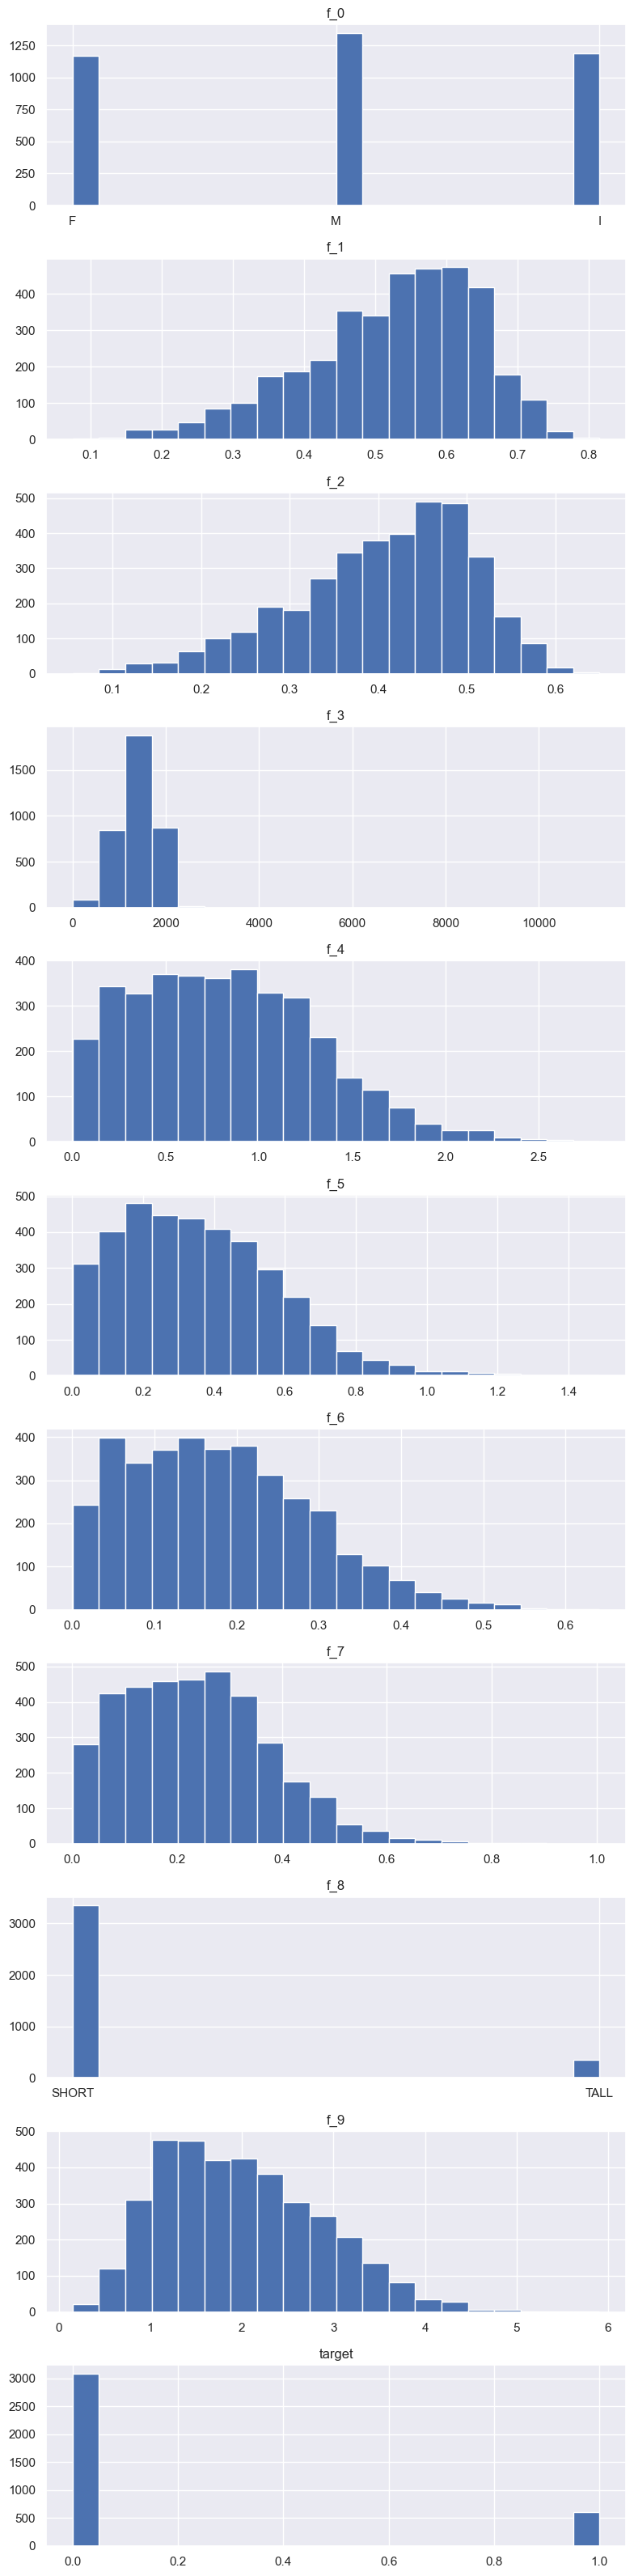

In [170]:
visualize(df)

The picture above shows that the dataset is imbalanced (target column). It’s important that it is balanced, because during the training process the model would greatly prefer 0 class over 1 class of the target column. That's why I select all class 1 values and "randomly" match them with the class 0 values. Since I've made changes to the dataset, I’ll conduct the visual inspection again.

In [196]:
df_targets_1 = df[df["target"] == 1]
df_targets_0 = df[df["target"] == 0].sample(n=len(df_targets_1), random_state=RANDOM_STATE)

df_balanced = pd.concat([df_targets_1, df_targets_0])
df_balanced = df_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In the next part, I want to see how the data looks when divided into individual groups according to the target column (0s and 1s). Thanks to these plots, I can look at their distributions. I can also find out if the data is skewed or if it contains any outliers. Since I personally think that the *id* column is no longer relevant (due to its high cardinality or sparse representation), I will not use it.

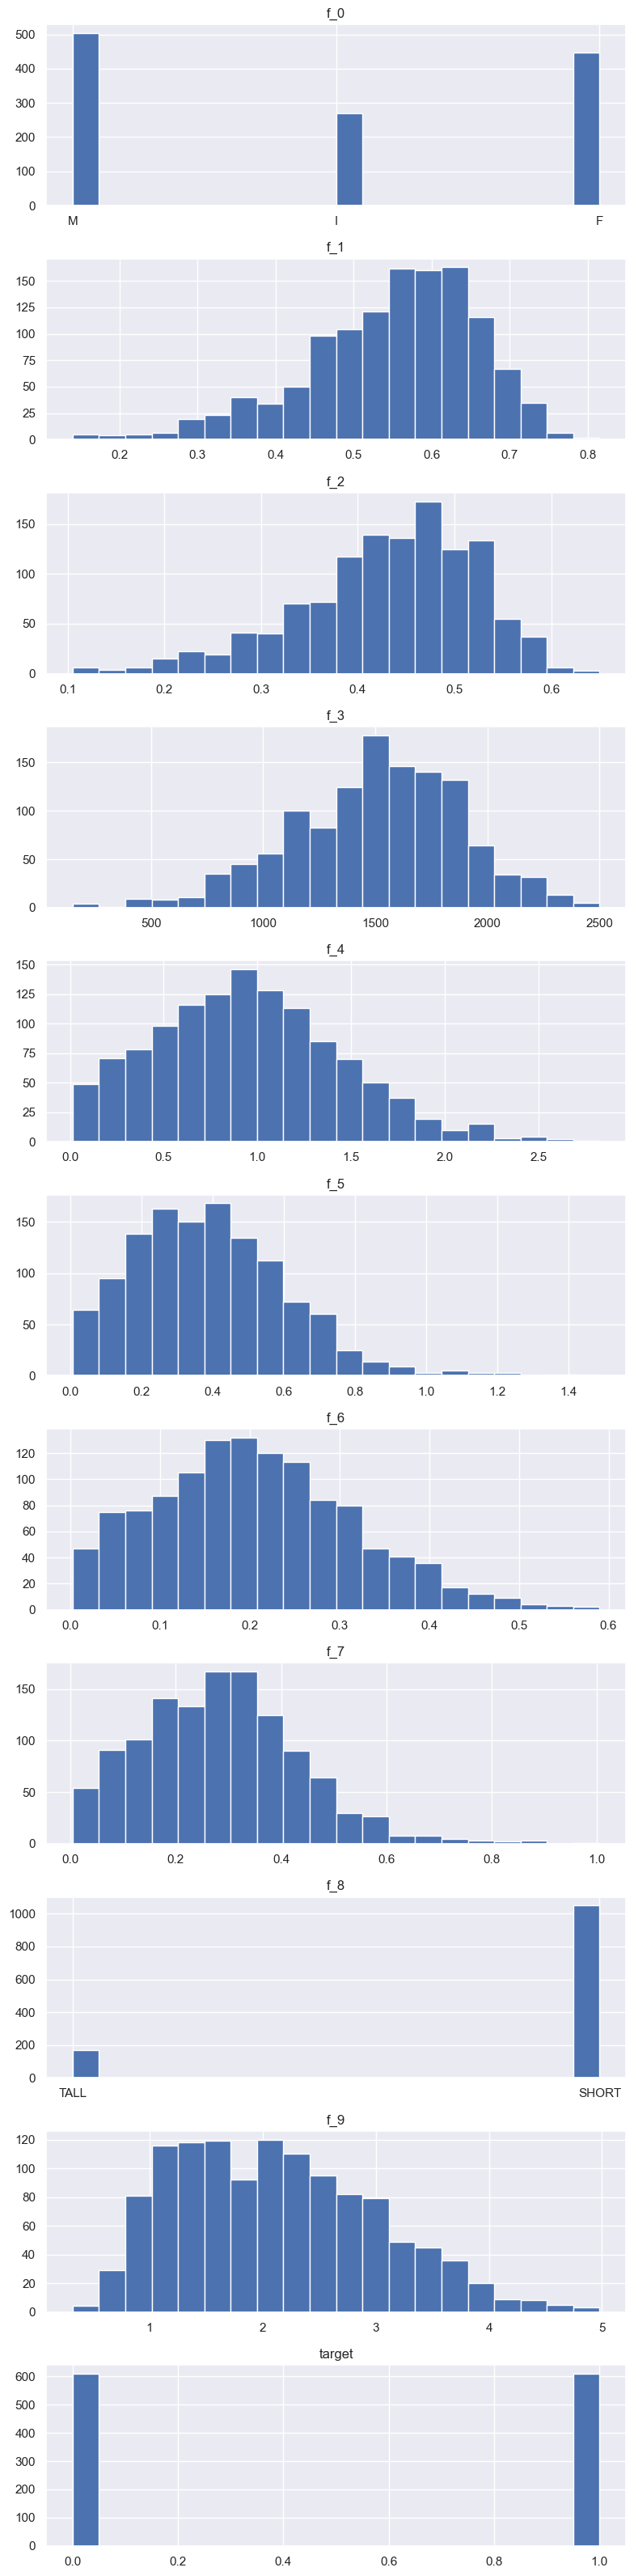

In [171]:
visualize(df_balanced)

In [180]:
def plot_histogram(
    df: pd.DataFrame
) -> None:
    """
    Plot histogram for selected columns (f_0 - f_9).
    """

    # Choose potentially interest columns for inpection
    columns_of_interest = [col for col in df.columns if col not in ["id", "target"]]

    # Create subplots
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))

    for i, column in enumerate(columns_of_interest):
        ax = axes.flatten()[i]
        ax.set_title(column)

        plot = sns.histplot(data=df, x=column, hue="target", bins=20, multiple="fill", ax=ax, palette="Set1")

        plot.set(xlabel=None)

    # Adjust layout and spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

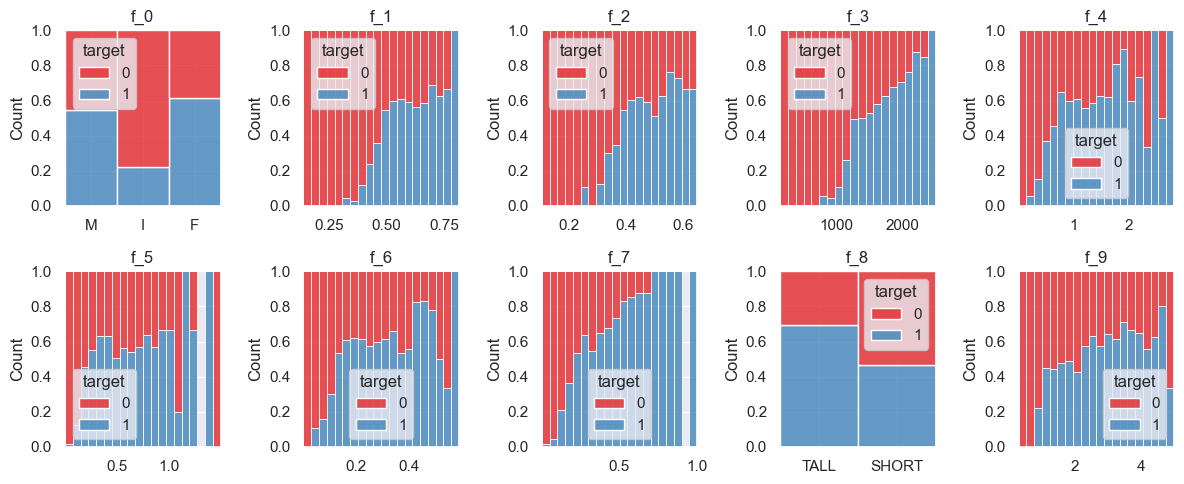

In [181]:
plot_histogram(df_balanced)

**Numerical data**

* These histograms show that columns *f_1*, *f_2*, *f_3*, and *f_7* follow similar trends. Smaller values represent almost 100% of target 0. Going further right (values are increasing) the target 1 are increasing as well.

* Regarding the columns *f_4*, *f_5*, *f_6*, and *f_9*, there is another trend. It’s similar to a bell-curve (normal distribution) where target 1 is preferential and then they decrease again at the end (target 0 is preferential). While this is a very bold statement, I can still see this trend, however small it is.

**Categorical data**

* The *f_0* follows mostly the same distribution (*M*, *F*). However, for the *I* values, the amount of target 0 is significantly greater than target 1. 


* In the *f_8* column, the *TALL* seems to be leaning towards target 0 (around 60%), while *SHORT* (around 40%) leans toward target 1


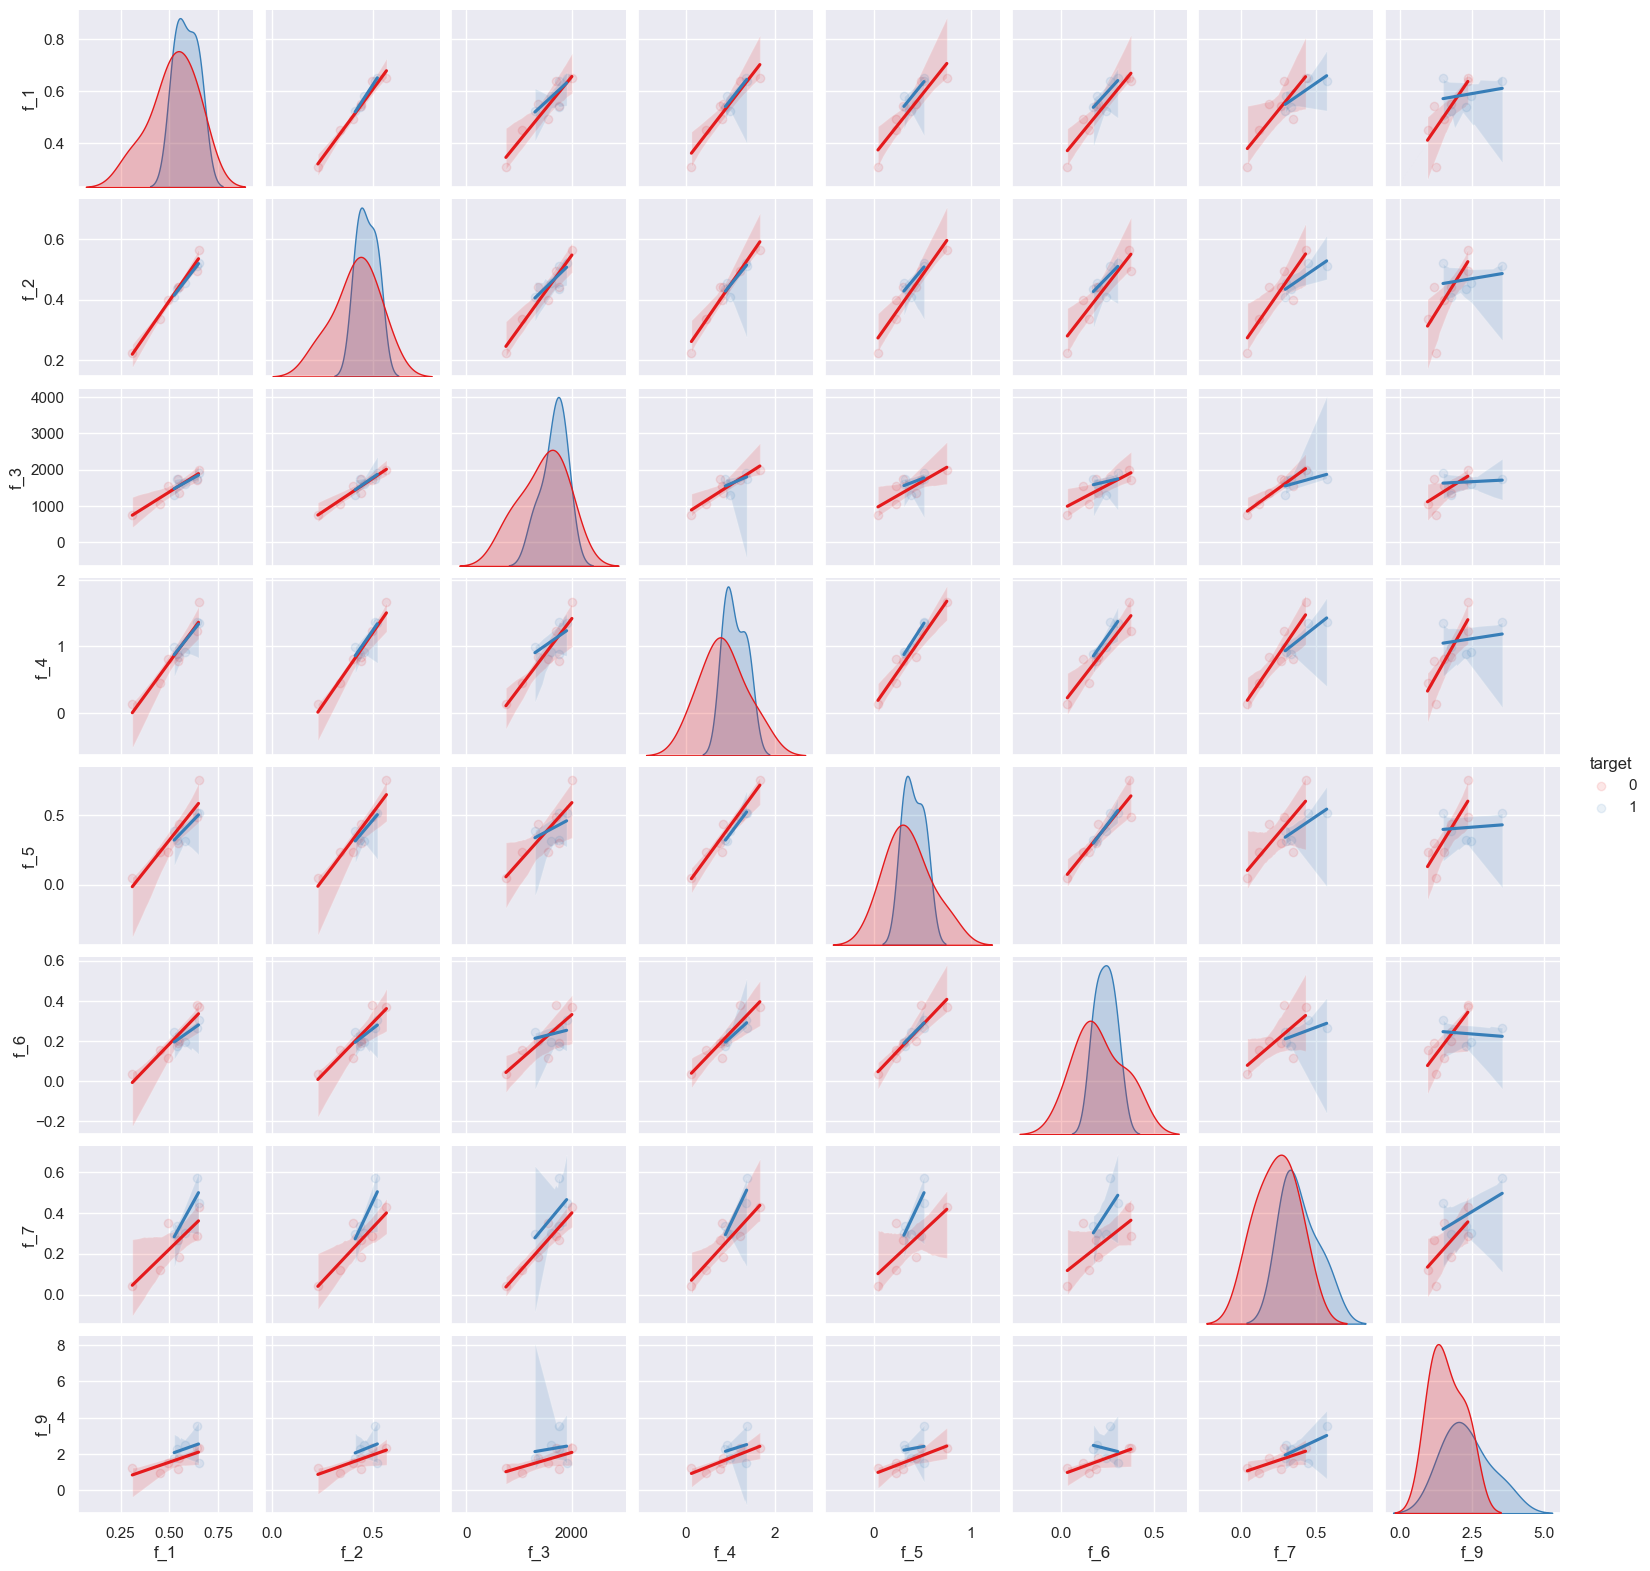

In [182]:
columns_of_interest = ["f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9", "target"]

sns.pairplot(df_balanced[columns_of_interest].sample(frac=0.01, random_state=RANDOM_STATE),
             kind="reg",
             hue="target",
             palette="Set1",
             plot_kws={"scatter_kws":{"alpha": 0.1}},
             height=2,
             aspect=1)

plt.show()

In many cases, the blue and red points significantly overlap, suggesting that some features might not provide strong discrimination between the two classes. I’ll confirm this later, with the help of Correlation matrix. Some features show a wide range of values with potential outliers or extreme values, which could affect model performance.


/var/folders/fh/x2kftj7s51z5v6sp0g9cgwlh0000gn/T/ipykernel_51338/2805579346.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_balanced["f_0_tmp"] = df_balanced["f_0"].replace(mapping_sex)
/var/folders/fh/x2kftj7s51z5v6sp0g9cgwlh0000gn/T/ipykernel_51338/2805579346.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_balanced["f_8_tmp"] = df_balanced["f_8"].replace(mapping_height)


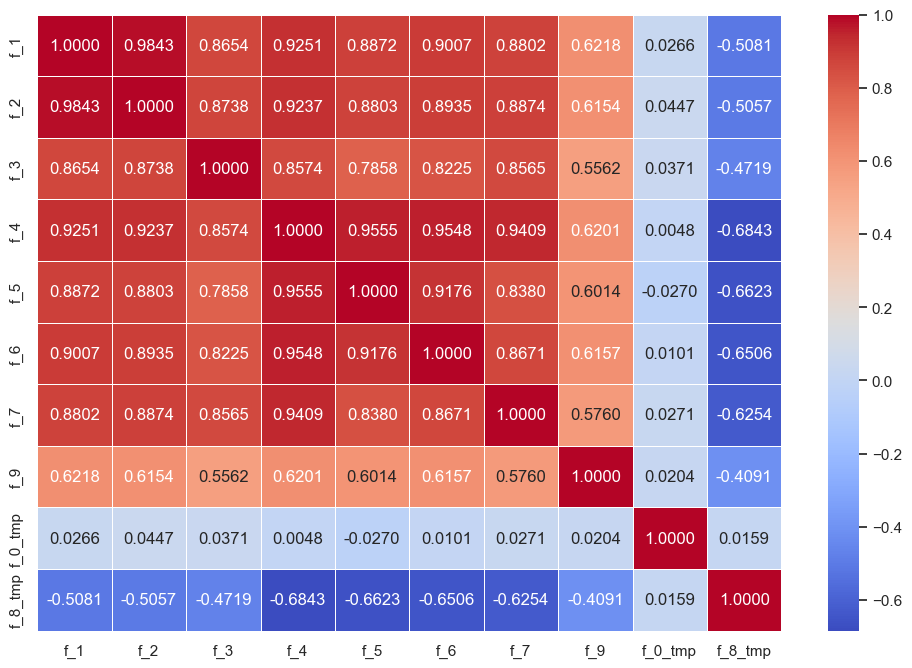

In [197]:
# Temporarily map categorical values into numerical ones
mapping_sex = {
    "M": -1,
    "F": 1,
    "I": 0
}

df_balanced["f_0_tmp"] = df_balanced["f_0"].replace(mapping_sex)

mapping_height = {
    "TALL": 0,
    "SHORT": 1
}

df_balanced["f_8_tmp"] = df_balanced["f_8"].replace(mapping_height)

# Choose interest columns for inpection
columns_of_interest = [col for col in df_balanced.columns if col not in ["id", "f_0", "f_8", "target"]]

# Create correlation matrix
correlation_matrix = df_balanced[columns_of_interest].corr()

# Create heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt="0.4f", linewidths=0.5)

plt.show()

This Correlation matrix shows that the columns *f_0_tmp*, *f_8_tmp*, and *f_9* are irrelevant (they have the lowest correlation coefficient). This means One-Hot encoding won’t be necessary (*f_0*, *f_8*)

The rest of the columns (*f_1*, *f_2*, *f_3*, *f_4*, *f_5*, *f_6*, and *f_7*) have very strong correlations - close to 1. I’m going to work with these columns later as they will be the input for the Neural Network.


### 1.6 Summary

As I have explained most things during individual inspection, I won’t be repeating myself. However, what I’d like to mention is that it is evident that this data does not have a very high correlation, and it will therefore be difficult to make a prediction.

As for the significant columns, I will work with **target** (y) and *f_1*, *f_2*, *f_3*, *f_4*, *f_5*, *f_6*, and *f_7* (X). The last thing I will mention is that the data also contains outliers. I will deal with them in the next section.


## 2. Feature Selection and Engineering

### 2.1 Remove unnecessary columns

In [198]:
columns_to_drop = ["id", "f_0", "f_0_tmp", "f_8", "f_8_tmp", "f_9"]
df_balanced.drop(columns_to_drop, axis=1, inplace=True)

In [199]:
df_balanced

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,target
0,0.625,0.470,1450.0,1.7855,0.6750,0.2470,0.3245,1
1,0.580,0.490,1950.0,1.3165,0.5305,0.2540,0.4100,1
2,0.620,0.470,1400.0,1.0325,0.3605,0.2240,0.3600,1
3,0.595,0.485,1500.0,1.0835,0.5305,0.2310,0.2760,0
4,0.600,0.500,1600.0,1.1220,0.5095,0.2560,0.3090,0
...,...,...,...,...,...,...,...,...
1215,0.685,0.530,1700.0,1.5600,0.6470,0.3830,0.4650,0
1216,0.515,0.395,1350.0,1.0070,0.4720,0.2495,0.2520,0
1217,0.345,0.255,900.0,0.2005,0.0940,0.0295,0.0630,0
1218,0.370,0.280,1050.0,0.2240,0.0815,0.0575,0.0750,0


### 2.2 Remove outliers

In order to increase the model’s performance, I decided to remove the outliers as the model is sensitive to them.

In [204]:
# Calculate the IQR for each column
Q1 = df_balanced.quantile(0.25)
Q3 = df_balanced.quantile(0.75)
IQR = Q3 - Q1

# Define a threshold for outlier detection (e.g., 1.5 times IQR)
threshold = 1.5

# Create a boolean mask indicating outliers
outliers_mask = ((df_balanced < (Q1 - threshold * IQR)) | (df_balanced > (Q3 + threshold * IQR))).any(axis=1)

# Remove rows with outliers
df_no_outliers = df_balanced[~outliers_mask]

# Reset index (very important step!)
df_no_outliers.reset_index(drop=True, inplace=True)


In [205]:
df_no_outliers

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,target
0,0.625,0.470,1450.0,1.7855,0.6750,0.2470,0.3245,1
1,0.580,0.490,1950.0,1.3165,0.5305,0.2540,0.4100,1
2,0.620,0.470,1400.0,1.0325,0.3605,0.2240,0.3600,1
3,0.595,0.485,1500.0,1.0835,0.5305,0.2310,0.2760,0
4,0.600,0.500,1600.0,1.1220,0.5095,0.2560,0.3090,0
...,...,...,...,...,...,...,...,...
1156,0.685,0.530,1700.0,1.5600,0.6470,0.3830,0.4650,0
1157,0.515,0.395,1350.0,1.0070,0.4720,0.2495,0.2520,0
1158,0.345,0.255,900.0,0.2005,0.0940,0.0295,0.0630,0
1159,0.370,0.280,1050.0,0.2240,0.0815,0.0575,0.0750,0


### 2.3 Scale data 

Scale each feature to a range between 0 and 1.

In [208]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_no_outliers), columns=df_no_outliers.columns)

In [209]:
df_scaled

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,target
0,0.702970,0.666667,0.475,0.777010,0.691974,0.489028,0.463780,1.0
1,0.613861,0.716049,0.725,0.560931,0.535249,0.503657,0.598425,1.0
2,0.693069,0.666667,0.450,0.430085,0.350868,0.440961,0.519685,1.0
3,0.643564,0.703704,0.500,0.453582,0.535249,0.455590,0.387402,0.0
4,0.653465,0.740741,0.550,0.471320,0.512473,0.507837,0.439370,0.0
...,...,...,...,...,...,...,...,...
1156,0.821782,0.814815,0.600,0.673117,0.661605,0.773250,0.685039,0.0
1157,0.485149,0.481481,0.425,0.418337,0.471800,0.494253,0.349606,0.0
1158,0.148515,0.135802,0.200,0.046763,0.061822,0.034483,0.051969,0.0
1159,0.198020,0.197531,0.275,0.057590,0.048265,0.092999,0.070866,0.0


In [210]:
df_scaled.groupby("target").count()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7
target,,,,,,,
0.0,578,578,578,578,578,578,578
1.0,583,583,583,583,583,583,583


The distribution of records remained the same even after removing outliers. We have dropped around 3000 records for each event. As I’ve said before, I’d rather have a smaller but properly cleaned dataset.


## 3. Model Building

### 3.1 Split dataset

I decided to divide the dataset into a training set and a test set in the ratio of 80:20. I have enough data for this task, so I can afford such a ratio.

In [212]:
X = df_scaled[["f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7"]]

In [213]:
X

,f_1,f_2,f_3,f_4,f_5,f_6,f_7
0,0.702970,0.666667,0.475,0.777010,0.691974,0.489028,0.463780
1,0.613861,0.716049,0.725,0.560931,0.535249,0.503657,0.598425
2,0.693069,0.666667,0.450,0.430085,0.350868,0.440961,0.519685
3,0.643564,0.703704,0.500,0.453582,0.535249,0.455590,0.387402
4,0.653465,0.740741,0.550,0.471320,0.512473,0.507837,0.439370
...,...,...,...,...,...,...,...
1156,0.821782,0.814815,0.600,0.673117,0.661605,0.773250,0.685039
1157,0.485149,0.481481,0.425,0.418337,0.471800,0.494253,0.349606
1158,0.148515,0.135802,0.200,0.046763,0.061822,0.034483,0.051969
1159,0.198020,0.197531,0.275,0.057590,0.048265,0.092999,0.070866


In [214]:
y = df_scaled["target"]

In [215]:
y

0       1.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
1156    0.0
1157    0.0
1158    0.0
1159    0.0
1160    0.0
Name: target, Length: 1161, dtype: float64

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=RANDOM_STATE)

In [233]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape:  ", X_test.shape)
print("y_test shape:  ", y_test.shape)

X_train shape:  (928, 7)
y_train shape:  (928,)
X_test shape:   (233, 7)
y_test shape:   (233,)


### 3.2 Build model

Since my goal is to predict the target based on the features (from *f_1* to *f_7*), it will be a simple classification task, where the output will be a number from range 0 to 1. This will be the model's prediction. The more the model will be inclined to one of those values, the more confident it will be about the prediction.

In [234]:
model = Sequential([
    Dense(64, activation="relu", kernel_initializer=he_normal(), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu", kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation="relu", kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

/Users/matusstas/Library/Caches/pypoetry/virtualenvs/audio-transcription-9xNtzTwm-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3.3 Train model

In [235]:
callbacks = [
    EarlyStopping(
        patience=5,
        verbose=1
    ),
    ReduceLROnPlateau(
        patience=5,
        factor=0.5,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/20
47/47 - 1s - 19ms/step - accuracy: 0.6577 - loss: 0.6365 - val_accuracy: 0.6667 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 2/20
47/47 - 0s - 2ms/step - accuracy: 0.7291 - loss: 0.5872 - val_accuracy: 0.7366 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 3/20
47/47 - 0s - 988us/step - accuracy: 0.7170 - loss: 0.5825 - val_accuracy: 0.7849 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 4/20
47/47 - 0s - 962us/step - accuracy: 0.7089 - loss: 0.5877 - val_accuracy: 0.8065 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 5/20
47/47 - 0s - 988us/step - accuracy: 0.7520 - loss: 0.5481 - val_accuracy: 0.8172 - val_loss: 0.5191 - learning_rate: 0.0010
Epoch 6/20
47/47 - 0s - 941us/step - accuracy: 0.7210 - loss: 0.5510 - val_accuracy: 0.8118 - val_loss: 0.4988 - learning_rate: 0.0010
Epoch 7/20
47/47 - 0s - 947us/step - accuracy: 0.7426 - loss: 0.5285 - val_accuracy: 0.8011 - val_loss: 0.4813 - learning_rate: 0.0010
Epoch 8/20
47/47 - 0s - 954us/step - accuracy: 0.7520 - lo

### 3.4 Show training history

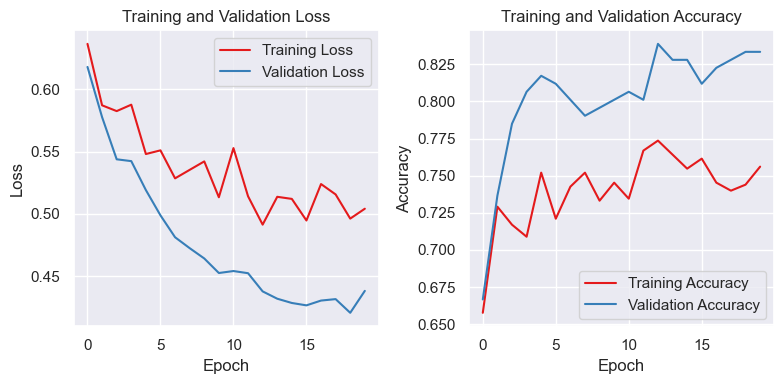

In [236]:
# Set palette
sns.set_palette("Set1")

# Set figure size
plt.figure(figsize=(8, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()

plt.show()

### 3.5 Save model

In [237]:
model.save("model.h5")

## 4. Model Evaluation and Reporting

### 4.1 Details of model

Even if I have enough data, the number of relevant features is not that many (from *f_1* to *f_7*), and therefore I decided that the complexity of the model (its architecture) cannot be so big. Rather, I focused on a smaller model so that it doesn't overfit, but learns important dependencies.

It is a sequential model that consists of 3 blocks + an output layer, where there is a sigmoid at the end. Each block contains Dense layer, Batch Normalization layer and Dropout layer. I set the activation functions to ReLU and also added the Kernel Initializer, which is responsible for initializing individual weights. The number of units gradually decreases, as does the percentage value that turns off the neurons. The model you see is the best I have managed to design. However, I didn't spend half a day on it to get 1 percent better results, for efficiency reasons.

Once I had my model created, I still needed to compile it. Here I have defined the Adam optimizer with an initial learning rate of 1e-6. I used Binary Crossentropy as a loss function (binary classification) and accuracy metric.

Finally, I defined callbacks that helped me find the optimal number of epochs for training the model. When the accuracy did not increase during the last 5 epochs, I ended the training. I also set a dynamic learning rate, where after 5 epochs it was reduced by half so that the accuracy did not stagnate. During training, I divided the training set in the ratio of 80:20, where I also worked with the validation set. I set the batch size to 16, based on the experiments performed, this turned out to be the best choice.


### 4.3 Performance metrics on the test dataset + Interpretation of the model's results

In order to be able to test the performance of the model, I chose several metrics, which are:

* accuracy
* precision
* recall
* f1-score
* type I error
* type II error
* ROC curve

In [238]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [239]:
# Show test accurary
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7854077253218884

In [240]:
def show_classification_report(y_test: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Show classification report on test set.
    """

    cr = classification_report(y_test, y_pred)
    print(cr)


show_classification_report(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.74      0.88      0.80       114
         1.0       0.86      0.70      0.77       119

    accuracy                           0.79       233
   macro avg       0.80      0.79      0.78       233
weighted avg       0.80      0.79      0.78       233



I see that the accuracy (the ratio of correctly predicted data to all data) represents 78.54% percent. Yes, it's not that much, but it's still better than a chance. However, let's see what the confusion matrix itself tells us.

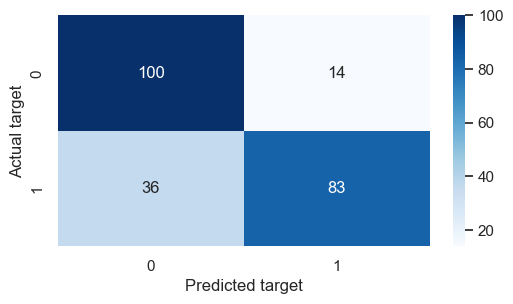

In [242]:
def show_confusion_matrix(y_test: np.ndarray, y_pred: np.ndarray, predicted_class: str) -> None:
    """Show confusion matrix."""

    sns.set(rc = {"figure.figsize":(6, 3)})

    cm = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(cm, annot=True, fmt="", cmap="Blues")

    ax.set_xlabel(f"Predicted {predicted_class}")
    ax.set_ylabel(f"Actual {predicted_class}")

    ax.xaxis.set_ticklabels(["0","1"])
    ax.yaxis.set_ticklabels(["0","1"])

    plt.show()


show_confusion_matrix(y_test, y_pred, predicted_class="target")


The optimal solution would be that false positives (type I error = click is considered an impression) and false negatives (type II error = impression is considered a click) would have a value equal to 0%. However, this is not the case, because I am moving at values of 26.47% for type I error and 14.43% for type II error. As for the correctly predicted classes, the model performed significantly better in predicting that a click is really a click (87.72%) than predicting that an impression is really an impression (73.53%).


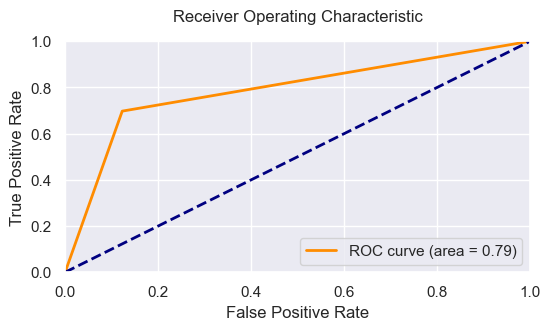

In [244]:
def show_roc_curve(y_test, y_pred):
    """
    Show Receiver Operating Characteristic (ROC) curve.
    """

    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)

    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = %0.2f)" % auc,
    )

    plt.plot([0, 1],
            [0, 1],
            color="navy",
            lw=2,
            linestyle="--")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.title("Receiver Operating Characteristic", y=1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    plt.legend(loc="lower right")
    
    plt.show()

show_roc_curve(y_test, y_pred)

If we were to look at the success of the model from the point of view of the ROC curve, we will find that the model is very close to chance. The optimal cut-off point is shown as a turning point between two orange lines in the plot. This is the point where the model has the highest sensitivity while maintaining a relatively high specificity.

## 5. Summary

I said a lot of things in the previous part, but here I would like to highlight a few important observations:

* Even though the dataset contained a large amount of data, I only worked with its subset to have a balanced dataset

* Since the dataset contained NaNs, outliers, and extremes, I had to correct it accordingly.

* Not many features were relevant (from *f_1* to *f_7*)

* Model performed significantly better in predicting that a click is really a click (87.72%) than predicting that an impression is really an impression (73.53%)
